In [40]:
import torch
import torch.nn as nn
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam

import torchvision
import torchvision.transforms as transforms


In [41]:
class Block(nn.Module):
  def __init__(self,ch_in,ch_out,downsample=None,stride=1):
    super(Block,self).__init__()
    self.expansion = 4
    self.con1=nn.Conv2d(ch_in,ch_out,kernel_size=1,stride=1,padding=0)
    self.bn1= nn.BatchNorm2d(ch_out)
    self.con2=nn.Conv2d(ch_out,ch_out,kernel_size=3,stride=stride,padding=1)
    self.bn2= nn.BatchNorm2d(ch_out)
    self.con3=nn.Conv2d(ch_out,ch_out*self.expansion,kernel_size=1,stride=1,padding=0)
    self.bn3= nn.BatchNorm2d(ch_out*self.expansion)
    self.relu=nn.ReLU()
    self.downsample=downsample

  def forward(self,inp):
    identity=inp

    inp=self.con1(inp)
    inp=self.bn1(inp)
    inp=self.relu(inp)
    inp=self.con2(inp)
    inp=self.bn2(inp)
    inp=self.relu(inp)
    inp=self.con3(inp)
    inp=self.bn3(inp)

    if self.downsample is not None:
      identity=self.downsample(identity)

    inp+= identity
    inp=self.relu(inp)
    return inp
    


In [42]:
class resnet(nn.Module):
  def __init__(self,Block,layers,image_channels, num_classes):
    super(resnet,self).__init__()
    self.ch_in=64
    self.con1=nn.Conv2d(image_channels,64,kernel_size=7,stride=2,padding=3)
    self.bn1=nn.BatchNorm2d(64)
    self.relu=nn.ReLU()
    self.maxpool=nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    #Resnet layers

    self.layer1=self.mk_layer(Block,layers[0],ch_out=64,stride=1)
    self.layer2=self.mk_layer(Block,layers[1],ch_out=128,stride=2)
    self.layer3=self.mk_layer(Block,layers[2],ch_out=256,stride=2)
    self.layer4=self.mk_layer(Block,layers[3],ch_out=512,stride=2)

    self.avgpool=nn.AdaptiveAvgPool2d((1,1))
    self.fc=nn.Linear(512*4,num_classes)

  def forward(self,inp):
    inp=self.con1(inp)
    inp=self.bn1(inp)
    inp=self.relu(inp)
    inp=self.maxpool(inp)

    inp=self.layer1(inp)
    inp=self.layer2(inp)
    inp=self.layer3(inp)
    inp=self.layer4(inp)

    inp=self.avgpool(inp)
    inp=inp.reshape(inp.shape[0],-1)
    inp=self.fc(inp)

    return inp

  def mk_layer(self,Block,num_res_block,ch_out,stride):
    downsample=None
    layers=[]

    if stride !=1 or self.ch_in!=ch_out*4:
      downsample=nn.Sequential(nn.Conv2d(self.ch_in,ch_out*4,kernel_size=1,stride=stride),nn.BatchNorm2d(ch_out*4))

    layers.append(Block(self.ch_in,ch_out,downsample,stride))
    self.ch_in=ch_out*4

    for i in range(num_res_block-1):
      layers.append(Block(self.ch_in,ch_out))
    
    return nn.Sequential(*layers)


In [43]:
def resnet18(image_channels=3,num_classes=10):
  return resnet(Block,[2,2,2,2],image_channels,num_classes)

In [44]:
net=resnet18()
x=torch.randn(2,3,224,224)
y=net(x)
print(y.shape)
print(y)

torch.Size([2, 10])
tensor([[-0.0814, -0.2759,  0.4148,  0.3545,  0.3379,  0.8018,  0.5555,  0.1772,
          0.2119, -0.3535],
        [ 0.0374, -0.1164,  0.4465,  0.2904,  0.4205,  0.8370,  0.2411,  0.1985,
          0.2379, -0.4107]], grad_fn=<AddmmBackward0>)


In [45]:
# Data Transformer
tfm = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=tfm)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=tfm)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
print(trainloader.dataset)

Files already downloaded and verified
Files already downloaded and verified
Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-10.0, 10.0], interpolation=nearest, expand=False, fill=0)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [46]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

In [47]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer=Adam(net.parameters(), lr=3e-4, weight_decay=0.0001)

In [48]:
for epoch in range(2):

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        if i<=2000:

          inputs, labels = data


          optimizer.zero_grad()


          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()


          running_loss += loss.item()
          if i % 2000 == 1999:    
              print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
              running_loss = 0.0
        else:
          break

print('Finished Training')

[1,  2000] loss: 2.101
[2,  2000] loss: 1.896
Finished Training


In [49]:
import matplotlib.pyplot as plt
import numpy as np

# function to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


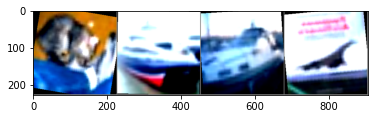

GroundTruth:  cat   ship  ship  airplane


In [50]:
dataiter = iter(testloader)
images, labels = next(dataiter)


imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [51]:
outputs = net(images)

In [52]:
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        if i<=300:

          images, labels = data

          outputs = net(images)

          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()
        else:
          break

print(f'Accuracy of the network on the 200 test images: {100 * correct // total} %')

Accuracy of the network on the 200 test images: 29 %


In [53]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}


with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        if i<=200:
          images, labels = data
          outputs = net(images)
          _, predictions = torch.max(outputs, 1)
          # collect the correct predictions for each class
          for label, prediction in zip(labels, predictions):
              if label == prediction:
                  correct_pred[classes[label]] += 1
              total_pred[classes[label]] += 1
        else:
          break

# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

Accuracy for class: airplane is 27.5 %
Accuracy for class: automobile is 46.3 %
Accuracy for class: bird  is 4.9 %
Accuracy for class: cat   is 14.1 %
Accuracy for class: deer  is 16.7 %
Accuracy for class: dog   is 60.0 %
Accuracy for class: frog  is 43.2 %
Accuracy for class: horse is 5.0 %
Accuracy for class: ship  is 45.2 %
Accuracy for class: truck is 56.5 %
